<a href="https://colab.research.google.com/github/atick-faisal/GRF-Synthesis-from-Motion-Trajectories/blob/main/src/training/grf_synthesis_x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get 1D-CNN lib from GitHub

In [1]:
!git clone https://github.com/atick-faisal/GRF-Synthesis-from-Motion-Trajectories.git
%cd /content/GRF-Synthesis-from-Motion-Trajectories/src/

fatal: destination path 'GRF-Synthesis-from-Motion-Trajectories' already exists and is not an empty directory.
/content/GRF-Synthesis-from-Motion-Trajectories/src


# Import libraries

In [2]:
import h5py
import scipy
import random
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from models import UNet

%matplotlib inline
sns.set_style('white')

# Download and prepare data

In [3]:
!gdown --id "1eZe_C5WhOGFqIZ01BvCkrg0RvTSM9Nqi"

Downloading...
From: https://drive.google.com/uc?id=1eZe_C5WhOGFqIZ01BvCkrg0RvTSM9Nqi
To: /content/GRF-Synthesis-from-Motion-Trajectories/src/data2.joblib
100% 578M/578M [00:03<00:00, 171MB/s]


In [4]:
DATASET_ID = 2
FRAME_LEN = 1024

data = joblib.load(f'data{DATASET_ID}.joblib')
features = data['X']
target = data['y']

if DATASET_ID == 1:
    features_x = features[['fal_x', 'tam_x', 'fcc_x', 'fm1_x', 'fm2_x', 'fm5_x']].to_numpy()
else:
    features_x = features[[
        '7_x', '8_x', '9_x', '10_x', '11_x',
        '7_z', '8_z', '9_z', '10_z', '11_z'
    ]].to_numpy()

target_x = target[['fx']].to_numpy()

N_CHANNELS = features_x.shape[1]

# feature_scaler_1 = StandardScaler()
feature_scaler_2 = MinMaxScaler()
# feature_scaler_1.fit(features_x)
# features_x = feature_scaler_1.transform(features_x)
feature_scaler_2.fit(features_x)
features_x = feature_scaler_2.transform(features_x)

# target_scaler_1 = StandardScaler()
target_scaler_2 = MinMaxScaler()
# target_scaler_1.fit(target_x)
# target_x = target_scaler_1.transform(target_x)
target_scaler_2.fit(target_x)
target_x = target_scaler_2.transform(target_x)

X = features_x.reshape(-1, FRAME_LEN, N_CHANNELS)
y = target_x.reshape(-1, FRAME_LEN)

# ... Change signs of left foot forces
# indices = np.arange(y.shape[0])
# negative_ones = np.repeat(-1, y.shape[0])
# sign_converter = np.power(negative_ones, indices).reshape(-1, 1)
# y = np.multiply(y, sign_converter)

print(X.shape)
print(y.shape)

(1960, 1024, 10)
(1960, 1024)


# Signal Verification

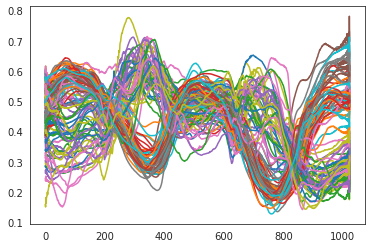

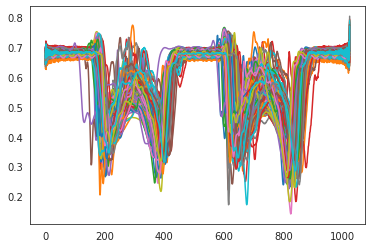

In [5]:
for i in range(100):
    plt.plot(X[i, :, 0])
plt.show()

for i in range(100):
    plt.plot(y[i, :])
plt.show()

# Train test split

In [6]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size=0.2, random_state=42)
Y_Train.shape

(1568, 1024)

# Configuration

In [7]:
model_name = 'UNet' # UNet or UNetPP
signal_length = FRAME_LEN # Length of each Segment
model_depth = 3 # Number of Level in the CNN Model
model_width = 64 # Width of the Initial Layer, subsequent layers start from here
kernel_size = 3 # Size of the Kernels/Filter
num_channel = N_CHANNELS # Number of Channels in the Model
D_S = 1 # Turn on Deep Supervision
A_E = 0 # Turn on AutoEncoder Mode for Feature Extraction
problem_type = 'Regression'
output_nums = 1 # Number of Class for Classification Problems, always '1' for Regression Problems
'''Only required if the AutoEncoder Mode is turned on'''
feature_number = 1024 # Number of Features to be Extracted
'''Only required for MultiResUNet'''
alpha = 1 # Model Width Expansion Parameter

# Prepare for deep supervision

In [8]:
def prepareTrainDict(y, model_depth, signal_length, model_name):
  def approximate(inp, w_len, signal_length):
    op = np.zeros((len(inp),signal_length//w_len))
    for i in range(0,signal_length,w_len):
      try:
        op[:,i//w_len] = np.mean(inp[:,i:i+w_len],axis=1)
      except Exception as e:
        print(e)
        print(i)
  	
    return op

  out = {}
  Y_Train_dict = {}
  out['out'] = np.array(y)
  Y_Train_dict['out'] = out['out']
  for i in range(1, (model_depth+1)):
    name = f'level{i}'
    if ((model_name == 'UNet') or (model_name == 'MultiResUNet') or (model_name == 'FPN')):
      out[name] = np.expand_dims(approximate(np.squeeze(y), 2**i, signal_length),axis = 2)
    elif ((model_name == 'UNetE') or (model_name == 'UNetP') or (model_name == 'UNetPP')):
      out[name] = np.expand_dims(approximate(np.squeeze(y), 2**0, signal_length),axis = 2)
    Y_Train_dict[f'level{i}'] = out[f'level{i}']
  
  return out, Y_Train_dict

In [9]:
X_Train1 = X_Train
X_Test1 = X_Test
[Y_Train1, Y_Train_dict] = prepareTrainDict(Y_Train, model_depth, signal_length, model_name)
[Y_Test1, Y_Test_dict] = prepareTrainDict(Y_Test, model_depth, signal_length, model_name)

In [10]:
loss_weights = np.zeros(model_depth)

for i in range(0, model_depth):
   loss_weights[i] = 1-(i*0.1)
   
loss_weights

array([1. , 0.9, 0.8])

# Build and compile model

In [11]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.001
)

if D_S == 0:
    # Build model for EEG Motion Artifact Removal - Deep Unet Architecture
    # AutoEncoder should be set at 'FALSE' for the Deep U-net model for Signal Reconstruction
    # D_S = 0, A_E = 0
    model = UNet(
        signal_length,
        model_depth,
        num_channel, 
        model_width, 
        kernel_size, 
        problem_type=problem_type, 
        output_nums=output_nums, 
        ds=D_S, ae=A_E, 
        alpha=alpha
    ).UNet()

    model.compile(
        loss= 'mean_absolute_error', 
        optimizer= optimizer, 
        metrics= ['mean_squared_error','accuracy']
    )
    #
elif D_S == 1:
    # Build model for EEG Motion Artifact Removal - Deep Unet Architecture
    # AutoEncoder should be set at 'FALSE' for the Deep U-net model for Signal Reconstruction
    # D_S = 1, A_E = 0
    model = UNet(
        signal_length, model_depth, 
        num_channel, 
        model_width, 
        kernel_size, 
        problem_type=problem_type, 
        output_nums=output_nums, 
        ds=D_S, ae=A_E, 
        alpha=alpha
    ).UNet()

    model.compile(
        loss= 'mean_absolute_error', 
        optimizer= optimizer, 
        metrics= ['mean_squared_error'], 
        loss_weights= loss_weights
    )

# Training

In [12]:
if D_S == 0:
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min'), 
        tf.keras.callbacks.ModelCheckpoint(
            'trained_models/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_' \
                +str(model_depth)+'_'+str(num_channel)+'_'+str(D_S)+'.h5', 
                verbose=1, 
                monitor='val_loss', 
                save_best_only=True, 
                mode='min'
        )
    ]
    history = model.fit(
        X_Train, Y_Train, 
        epochs=300, 
        batch_size=64, 
        verbose=1, 
        validation_split=0.2, 
        shuffle=True, 
        callbacks=callbacks
    )
    
elif D_S == 1:
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_out_loss', patience=30, mode='min'), 
        tf.keras.callbacks.ModelCheckpoint(
            'trained_models/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_' \
                +str(model_depth)+'_'+str(num_channel)+'_'+str(D_S)+'.h5', 
                verbose=1, 
                monitor='val_out_loss', 
                save_best_only=True, 
                mode='min'
        )
    ]
    history = model.fit(
        X_Train1, 
        Y_Train_dict, 
        epochs=300, 
        batch_size=64, 
        verbose=1, 
        validation_split=0.2, 
        shuffle=True, 
        callbacks=callbacks
    )

Epoch 1/300
20/20 [==============================] - 23s 458ms/step - loss: 1.2059 - out_loss: 0.2041 - level1_loss: 0.2531 - level2_loss: 0.3073 - level3_loss: 0.5754 - out_mean_squared_error: 0.1362 - level1_mean_squared_error: 0.3088 - level2_mean_squared_error: 0.5451 - level3_mean_squared_error: 1.4741 - val_loss: 4.1246 - val_out_loss: 0.8965 - val_level1_loss: 1.6353 - val_level2_loss: 1.3506 - val_level3_loss: 0.7006 - val_out_mean_squared_error: 1.0886 - val_level1_mean_squared_error: 3.9639 - val_level2_mean_squared_error: 2.4824 - val_level3_mean_squared_error: 0.5415

Epoch 00001: val_out_loss improved from inf to 0.89646, saving model to trained_models/UNet_1024_64_3_10_1.h5
Epoch 2/300
20/20 [==============================] - 7s 333ms/step - loss: 0.2305 - out_loss: 0.0589 - level1_loss: 0.0609 - level2_loss: 0.0718 - level3_loss: 0.0645 - out_mean_squared_error: 0.0077 - level1_mean_squared_error: 0.0118 - level2_mean_squared_error: 0.0184 - level3_mean_squared_error: 0.

# Prediction

In [13]:
if D_S == 0:
    GRF_pred = model.predict(X_Test, verbose=1)
    print(GRF_pred.shape)
elif D_S == 1:
    GRF_pred = model.predict(X_Test1, verbose=1)
    print(GRF_pred[0].shape)

13/13 [==============================] - 2s 63ms/step
(392, 1024, 1)


# Learning curves

dict_keys(['loss', 'out_loss', 'level1_loss', 'level2_loss', 'level3_loss', 'out_mean_squared_error', 'level1_mean_squared_error', 'level2_mean_squared_error', 'level3_mean_squared_error', 'val_loss', 'val_out_loss', 'val_level1_loss', 'val_level2_loss', 'val_level3_loss', 'val_out_mean_squared_error', 'val_level1_mean_squared_error', 'val_level2_mean_squared_error', 'val_level3_mean_squared_error'])


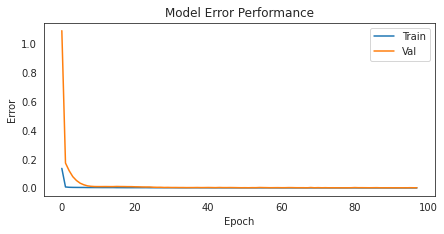

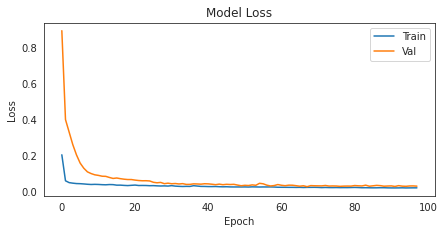

In [14]:
def history_plot(history):
    # list all dictionaries in history
    print(history.history.keys())
    # summarize history for error
    plt.figure(figsize=(7,7))
    plt.subplot(2,1,1)
    plt.plot(history.history['out_mean_squared_error'])
    plt.plot(history.history['val_out_mean_squared_error'])
    plt.title('Model Error Performance')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    #   plt.ylim([0, 3])
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(7,7))
    plt.subplot(2,1,2)
    plt.plot(history.history['out_loss'])
    plt.plot(history.history['val_out_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    #   plt.ylim([0, 3])
    plt.show()
#
history_plot(history)

# Visualize outcomes

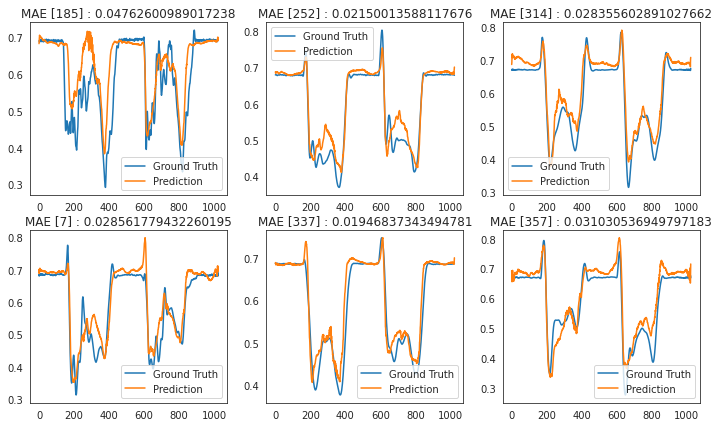

In [15]:
if D_S == 0:
    random_idx = random.sample(range(0, Y_Test.shape[0]), 6)
    plt.figure(figsize=(12, 7))
    for i in range(6):
        y_true = Y_Test[random_idx[i]]
        y_pred = GRF_pred[random_idx[i]]
        MAE = np.mean(np.abs(y_pred.ravel() - y_true.ravel()))
        plt.subplot(2, 3, i + 1)
        plt.plot(y_true, label='Ground Truth')
        plt.plot(y_pred.ravel(), label='Prediction')
        plt.title(f"MAE [{random_idx[i]}] : {MAE}")
        plt.legend();
    plt.show()
    
elif D_S == 1:
    random_idx = random.sample(range(0, Y_Test.shape[0]), 6)
    plt.figure(figsize=(12, 7))
    for i in range(6):
        y_true = Y_Test[random_idx[i]]
        y_pred = GRF_pred[0][random_idx[i]]
        MAE = np.mean(np.abs(y_pred.ravel() - y_true.ravel()))
        plt.subplot(2, 3, i + 1)
        plt.plot(y_true, label='Ground Truth')
        plt.plot(y_pred.ravel(), label='Prediction')
        plt.title(f"MAE [{random_idx[i]}] : {MAE}")
        plt.legend();
    plt.show()

# Construction Error

In [16]:
def Construction_Error(GRND, Pred):
    construction_err = []
    bad_indices = []
    count = 0

    for i in range(len(GRND)):
        MAE = np.mean(np.abs(Pred[i].ravel() - GRND[i].ravel()))
        if MAE < 1:
            construction_err.append(MAE)
        elif MAE >= 1:
            count = count + 1
            bad_indices.append(i)

    print(f'Construction Error : {round(np.mean(construction_err), 3)} +/- {round(np.std(construction_err), 3)}')
    print(f'Number of Bad Predictions = {count}')

    bad_indices = set(bad_indices)
    all_indices = set(np.arange(len(GRND)))
    good_indices = np.array(list(all_indices - bad_indices))
    GRND_NEW = GRND[good_indices]
    PRED_NEW = Pred[good_indices]

    return GRND_NEW, PRED_NEW

In [17]:
[A,B] = Construction_Error(Y_Test, GRF_pred[0])

Construction Error : 0.029 +/- 0.009
Number of Bad Predictions = 0


# Infinite loop to keep colab alive

In [18]:
while True:
    pass

KeyboardInterrupt: ignored